In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
#fix seed
seed = 104
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.enabled=False
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

## Load Data

In [3]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_paper_source_final/mb_paper_source_final.npy'
target_img_path = head / 'data/mb_paper_target_final/mb_paper_target_final.npy'
source_meta = head / 'data/mb_paper_source_final/mb_paper_source_final_metadata.csv'
target_meta = head / 'data/mb_paper_target_final/mb_paper_target_final_metadata.csv'
batch_size = 64
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

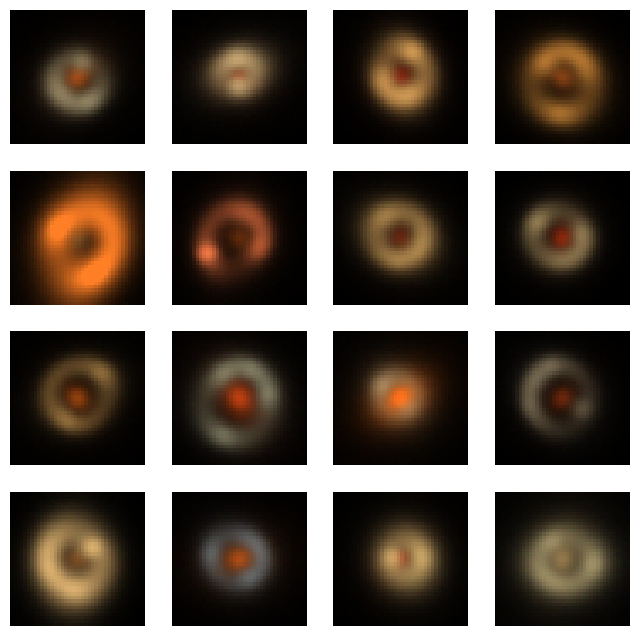

In [4]:
# Visualize source data
visualize_data(source_data)

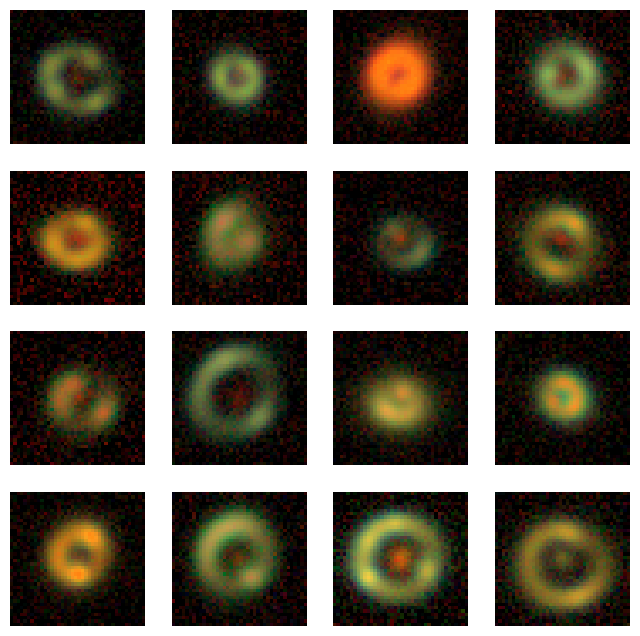

In [5]:
# Visualize target data
visualize_data(target_data)

## Model Setup

In [6]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
    return 0

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    beta_val = beta_init - (beta_init - beta_final) * (epoch / n_epoch)
    return beta_val

# Initialize hyperparameters
learning_rate = 3e-5
n_epoch = 250
extra_epoch = n_epoch
init_wt_da = 1.4
final_wt_da = 1.0
beta_init = 1.0
beta_final = 0.0

In [7]:
# Initialize model
model = NeuralNetworkMVE(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# To continue training from a past model, enter path into load_mod_name
# Else, enter None, and you still have to run the function.
# Then, enter save_mod_name to save for the current run  

load_mod_name = None # "models/start_code_test_2"
stats, model, optimizer, best_target_R2, best_mve_loss = initialize_state(load_mod_name, model, optimizer)


#save_mod_name = load_mod_name # may overwrite loaded model
save_mod_name = "models/papermvenoDA_v1_aug20_2000_B_104"

## Train

Beginning Training...
Generating Isomap...


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


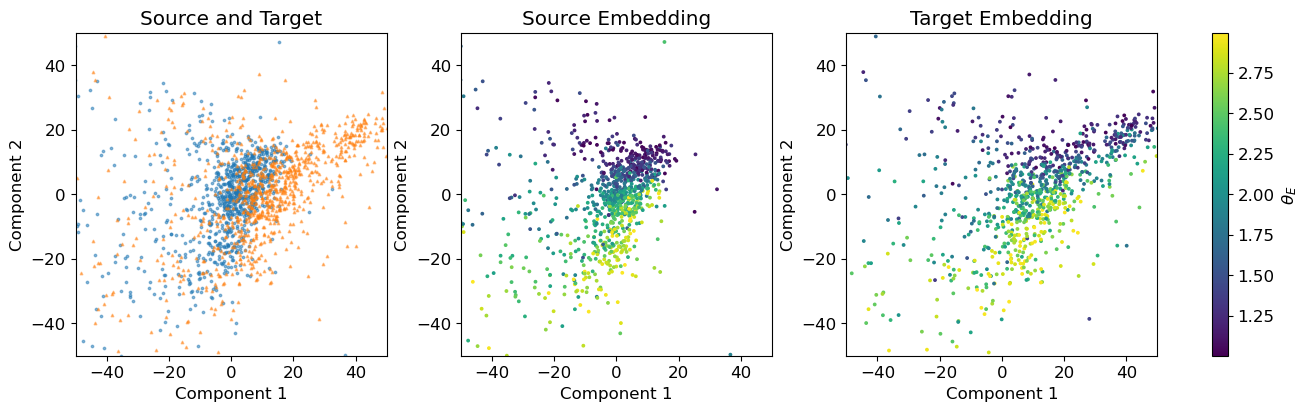


Epoch 0: 56.48s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.4090
	Train Regression Loss: : 1.2758
	Train Mve Loss: : 0.5210
	Train R2 Score: : -2.9198
 Validation Statistics:
	Val Source Regression Loss: : 0.2751
	Val Target Regression Loss: : 0.3051
	Val Source R2 Score: : 0.1541
	Val Target R2 Score: : 0.0885
	Val Source Mve Loss: : -0.0151
	Val Target Mve Loss: : -0.0027
Saving Model... Done.
Saving Model MVE... Done.

Epoch 1: 57.83s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3864
	Train Regression Loss: : 0.1681
	Train Mve Loss: : -0.0790
	Train R2 Score: : 0.4877
 Validation Statistics:
	Val Source Regression Loss: : 0.0901
	Val Target Regression Loss: : 0.1299
	Val Source R2 Score: : 0.7218
	Val Target R2 Score: : 0.6120
	Val Source Mve Loss: : -0.0888
	Val Target Mve Loss: : -0.0294
Saving Model... Done.
Saving Model MVE... Done.

Epoch 2: 58.49s
-------------------------------
 Training Statistics:
	Train Da Loss: :

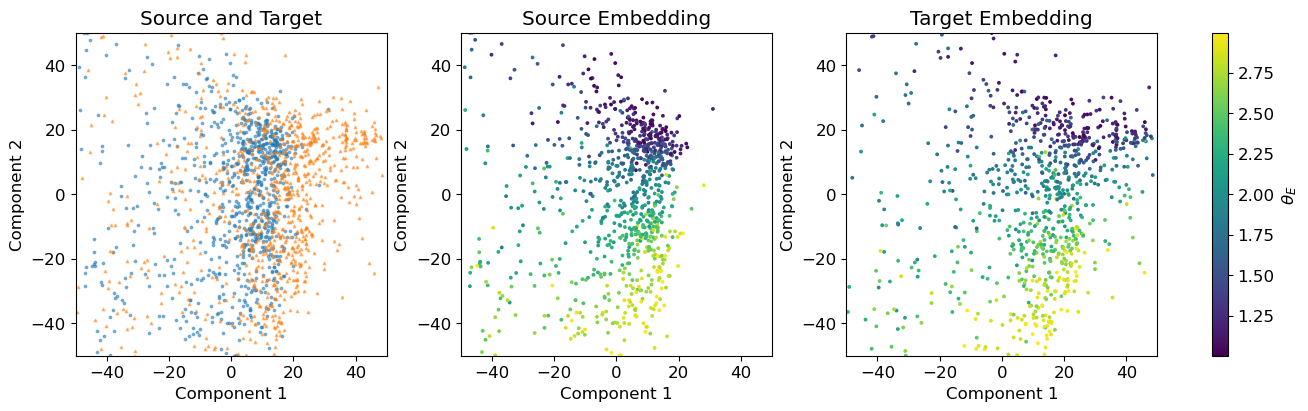


Epoch 20: 65.67s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3593
	Train Regression Loss: : 0.0139
	Train Mve Loss: : -0.0980
	Train R2 Score: : 0.9574
 Validation Statistics:
	Val Source Regression Loss: : 0.0145
	Val Target Regression Loss: : 0.1570
	Val Source R2 Score: : 0.9551
	Val Target R2 Score: : 0.5253
	Val Source Mve Loss: : -0.1657
	Val Target Mve Loss: : -0.0413

Epoch 21: 60.67s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3501
	Train Regression Loss: : 0.0139
	Train Mve Loss: : -0.0839
	Train R2 Score: : 0.9575
 Validation Statistics:
	Val Source Regression Loss: : 0.0136
	Val Target Regression Loss: : 0.1629
	Val Source R2 Score: : 0.9574
	Val Target R2 Score: : 0.5102
	Val Source Mve Loss: : -0.0795
	Val Target Mve Loss: : 0.1569

Epoch 22: 68.57s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3552
	Train Regression Loss: : 0.0134
	Train Mve Loss: : -0.0661
	Train R2 Score: : 0.9588


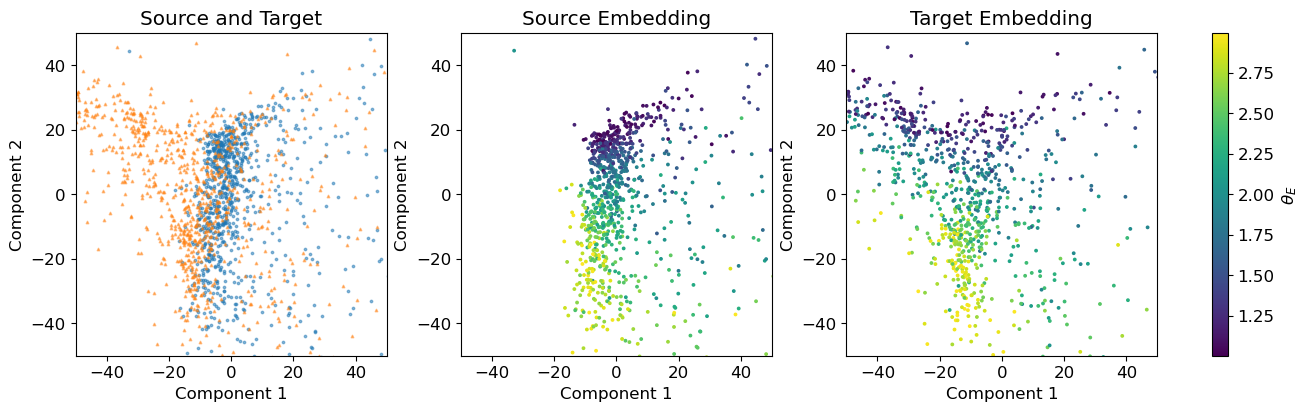


Epoch 40: 61.51s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.4544
	Train Regression Loss: : 0.0095
	Train Mve Loss: : -0.0778
	Train R2 Score: : 0.9709
 Validation Statistics:
	Val Source Regression Loss: : 0.0095
	Val Target Regression Loss: : 0.2789
	Val Source R2 Score: : 0.9703
	Val Target R2 Score: : 0.1626
	Val Source Mve Loss: : -0.0508
	Val Target Mve Loss: : 1.6086

Epoch 41: 58.18s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.4640
	Train Regression Loss: : 0.0095
	Train Mve Loss: : -0.1302
	Train R2 Score: : 0.9709
 Validation Statistics:
	Val Source Regression Loss: : 0.0102
	Val Target Regression Loss: : 0.3053
	Val Source R2 Score: : 0.9683
	Val Target R2 Score: : 0.0805
	Val Source Mve Loss: : -0.1885
	Val Target Mve Loss: : 0.8115

Epoch 42: 57.01s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.4788
	Train Regression Loss: : 0.0094
	Train Mve Loss: : -0.1126
	Train R2 Score: : 0.9711
 

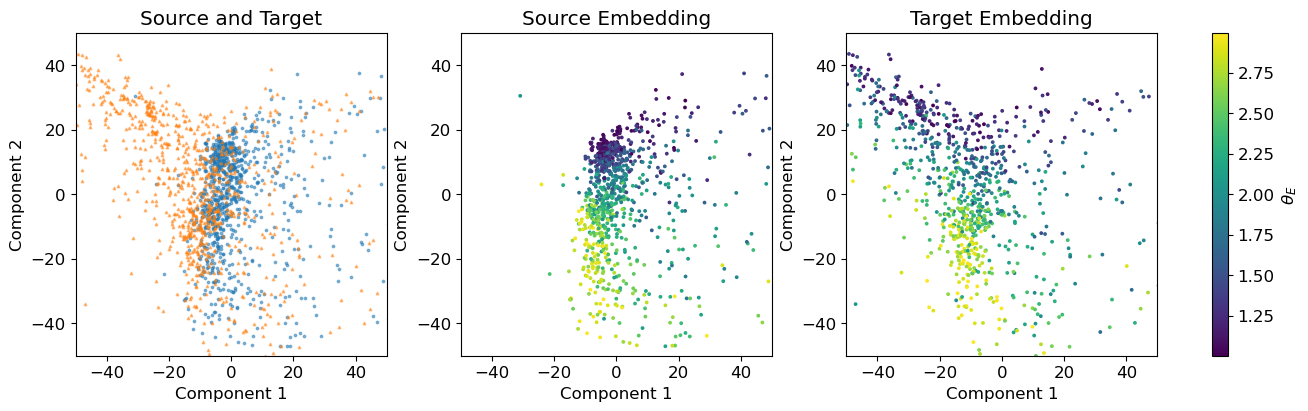


Epoch 60: 59.33s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.4768
	Train Regression Loss: : 0.0074
	Train Mve Loss: : -0.0673
	Train R2 Score: : 0.9774
 Validation Statistics:
	Val Source Regression Loss: : 0.0072
	Val Target Regression Loss: : 0.3278
	Val Source R2 Score: : 0.9776
	Val Target R2 Score: : 0.0084
	Val Source Mve Loss: : -0.1997
	Val Target Mve Loss: : 1.3115

Epoch 61: 66.08s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.4968
	Train Regression Loss: : 0.0077
	Train Mve Loss: : -0.1779
	Train R2 Score: : 0.9764
 Validation Statistics:
	Val Source Regression Loss: : 0.0075
	Val Target Regression Loss: : 0.3179
	Val Source R2 Score: : 0.9767
	Val Target R2 Score: : 0.0487
	Val Source Mve Loss: : -0.0956
	Val Target Mve Loss: : 5.0802

Epoch 62: 65.64s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.4866
	Train Regression Loss: : 0.0074
	Train Mve Loss: : -0.1048
	Train R2 Score: : 0.9773
 

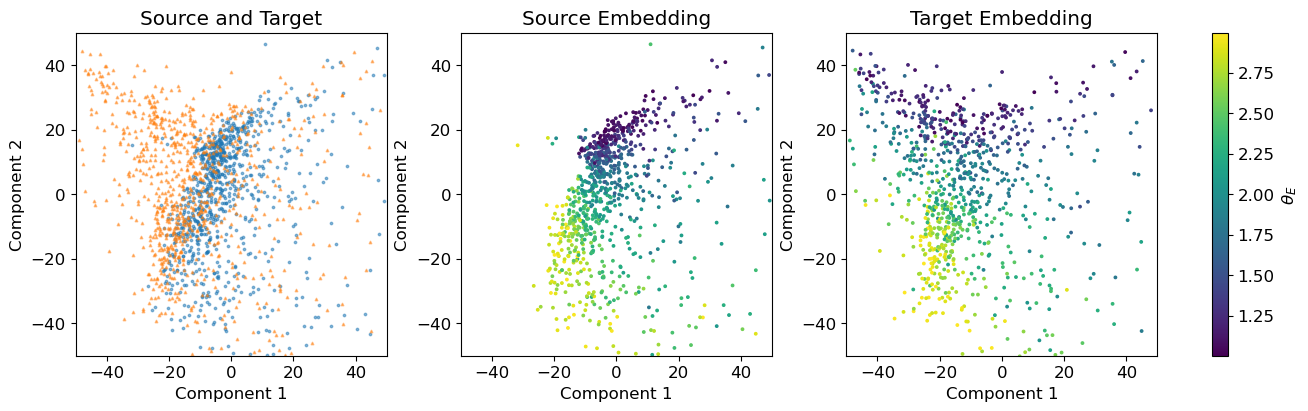


Epoch 80: 69.51s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.4072
	Train Regression Loss: : 0.0059
	Train Mve Loss: : -0.1650
	Train R2 Score: : 0.9819
 Validation Statistics:
	Val Source Regression Loss: : 0.0062
	Val Target Regression Loss: : 0.3567
	Val Source R2 Score: : 0.9808
	Val Target R2 Score: : -0.0778
	Val Source Mve Loss: : -0.2196
	Val Target Mve Loss: : 4.3895

Epoch 81: 64.79s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.4119
	Train Regression Loss: : 0.0058
	Train Mve Loss: : -0.1014
	Train R2 Score: : 0.9822
 Validation Statistics:
	Val Source Regression Loss: : 0.0062
	Val Target Regression Loss: : 0.3374
	Val Source R2 Score: : 0.9808
	Val Target R2 Score: : -0.0221
	Val Source Mve Loss: : -0.1416
	Val Target Mve Loss: : 13.3283

Epoch 82: 68.36s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3913
	Train Regression Loss: : 0.0055
	Train Mve Loss: : -0.0382
	Train R2 Score: : 0.983

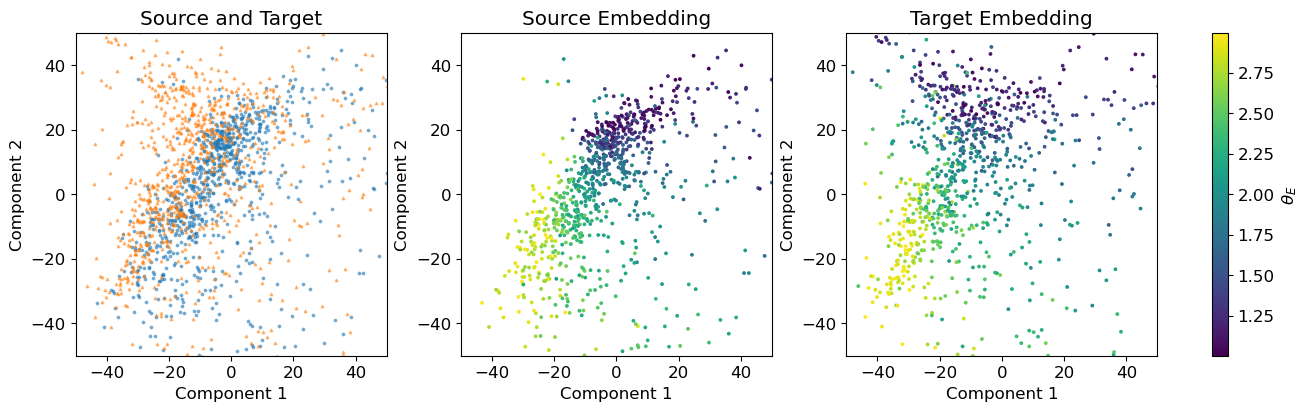


Epoch 100: 62.51s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3177
	Train Regression Loss: : 0.0037
	Train Mve Loss: : -0.2047
	Train R2 Score: : 0.9885
 Validation Statistics:
	Val Source Regression Loss: : 0.0040
	Val Target Regression Loss: : 0.2126
	Val Source R2 Score: : 0.9874
	Val Target R2 Score: : 0.3599
	Val Source Mve Loss: : -0.2068
	Val Target Mve Loss: : 27.6750

Epoch 101: 62.41s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3178
	Train Regression Loss: : 0.0037
	Train Mve Loss: : -0.2005
	Train R2 Score: : 0.9885
 Validation Statistics:
	Val Source Regression Loss: : 0.0037
	Val Target Regression Loss: : 0.2214
	Val Source R2 Score: : 0.9887
	Val Target R2 Score: : 0.3326
	Val Source Mve Loss: : -0.1818
	Val Target Mve Loss: : 38.2905

Epoch 102: 66.43s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3152
	Train Regression Loss: : 0.0036
	Train Mve Loss: : -0.0711
	Train R2 Score: : 0.9

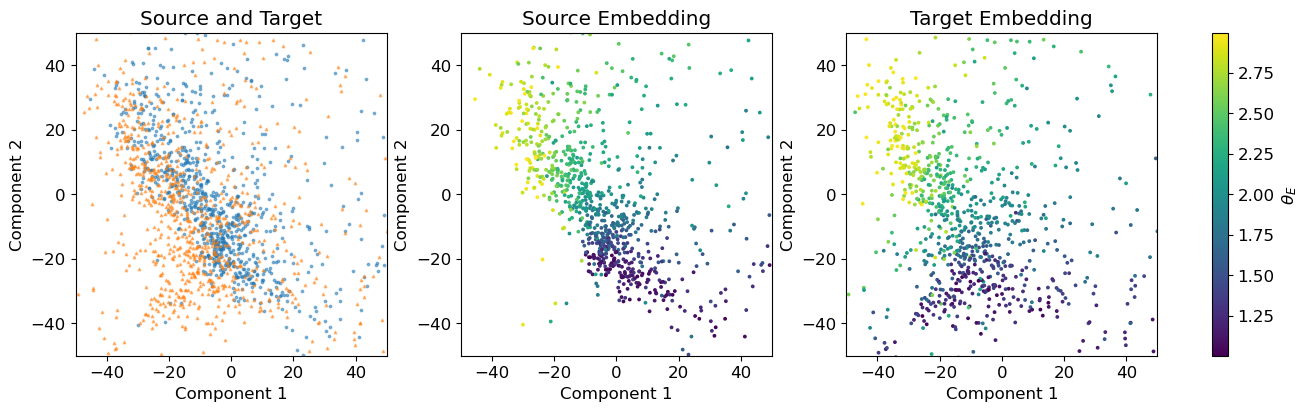


Epoch 120: 70.89s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2627
	Train Regression Loss: : 0.0028
	Train Mve Loss: : 0.0007
	Train R2 Score: : 0.9914
 Validation Statistics:
	Val Source Regression Loss: : 0.0027
	Val Target Regression Loss: : 0.2236
	Val Source R2 Score: : 0.9915
	Val Target R2 Score: : 0.3310
	Val Source Mve Loss: : 0.3741
	Val Target Mve Loss: : 158.7620

Epoch 121: 60.66s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2624
	Train Regression Loss: : 0.0028
	Train Mve Loss: : 0.2156
	Train R2 Score: : 0.9916
 Validation Statistics:
	Val Source Regression Loss: : 0.0027
	Val Target Regression Loss: : 0.2229
	Val Source R2 Score: : 0.9915
	Val Target R2 Score: : 0.3332
	Val Source Mve Loss: : 0.5304
	Val Target Mve Loss: : 240.6311

Epoch 122: 63.81s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2637
	Train Regression Loss: : 0.0027
	Train Mve Loss: : 0.1895
	Train R2 Score: : 0.9917

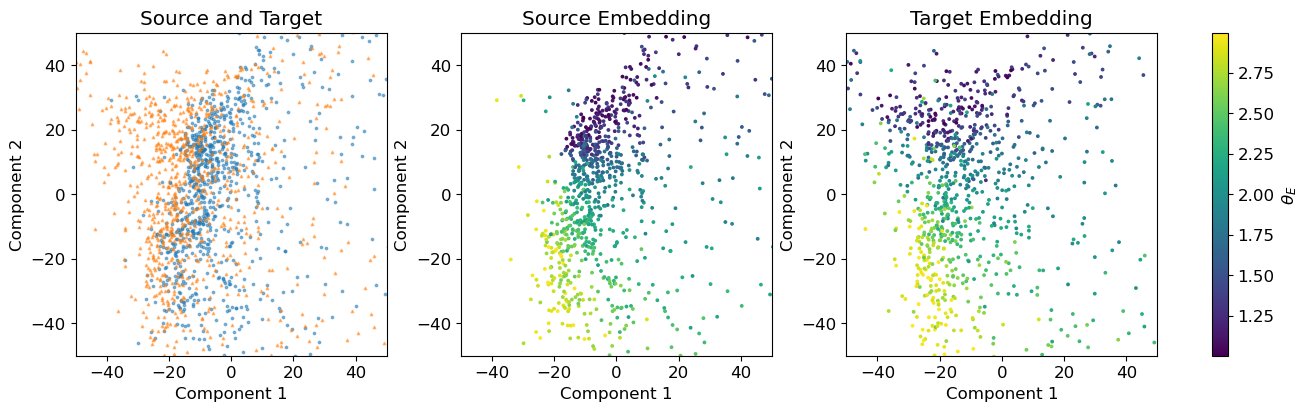


Epoch 140: 68.39s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2470
	Train Regression Loss: : 0.0042
	Train Mve Loss: : -0.3061
	Train R2 Score: : 0.9870
 Validation Statistics:
	Val Source Regression Loss: : 0.0044
	Val Target Regression Loss: : 0.1943
	Val Source R2 Score: : 0.9862
	Val Target R2 Score: : 0.4172
	Val Source Mve Loss: : -0.3114
	Val Target Mve Loss: : 31.6241

Epoch 141: 62.67s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2489
	Train Regression Loss: : 0.0051
	Train Mve Loss: : -0.3189
	Train R2 Score: : 0.9842
 Validation Statistics:
	Val Source Regression Loss: : 0.0061
	Val Target Regression Loss: : 0.1956
	Val Source R2 Score: : 0.9811
	Val Target R2 Score: : 0.4132
	Val Source Mve Loss: : -0.3278
	Val Target Mve Loss: : 67.7465

Epoch 142: 62.86s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2487
	Train Regression Loss: : 0.0062
	Train Mve Loss: : -0.3179
	Train R2 Score: : 0.9

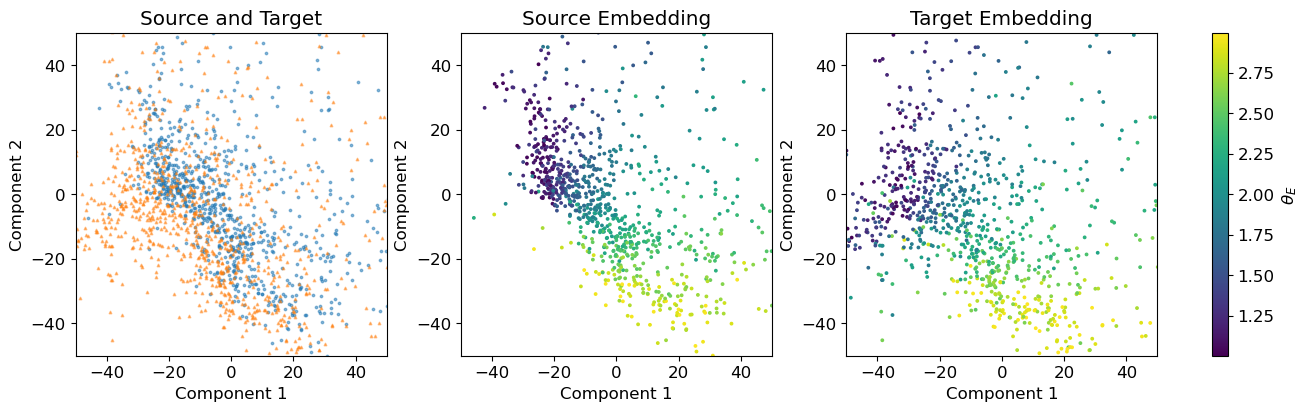


Epoch 160: 61.18s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2488
	Train Regression Loss: : 0.0033
	Train Mve Loss: : 0.4185
	Train R2 Score: : 0.9897
 Validation Statistics:
	Val Source Regression Loss: : 0.0035
	Val Target Regression Loss: : 0.2071
	Val Source R2 Score: : 0.9891
	Val Target R2 Score: : 0.3790
	Val Source Mve Loss: : -0.3361
	Val Target Mve Loss: : 2070.6190

Epoch 161: 62.15s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2486
	Train Regression Loss: : 0.0035
	Train Mve Loss: : -0.3483
	Train R2 Score: : 0.9893
 Validation Statistics:
	Val Source Regression Loss: : 0.0030
	Val Target Regression Loss: : 0.1929
	Val Source R2 Score: : 0.9908
	Val Target R2 Score: : 0.4183
	Val Source Mve Loss: : -0.4523
	Val Target Mve Loss: : 1672.7672

Epoch 162: 58.86s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2520
	Train Regression Loss: : 0.0034
	Train Mve Loss: : -0.3512
	Train R2 Score: : 

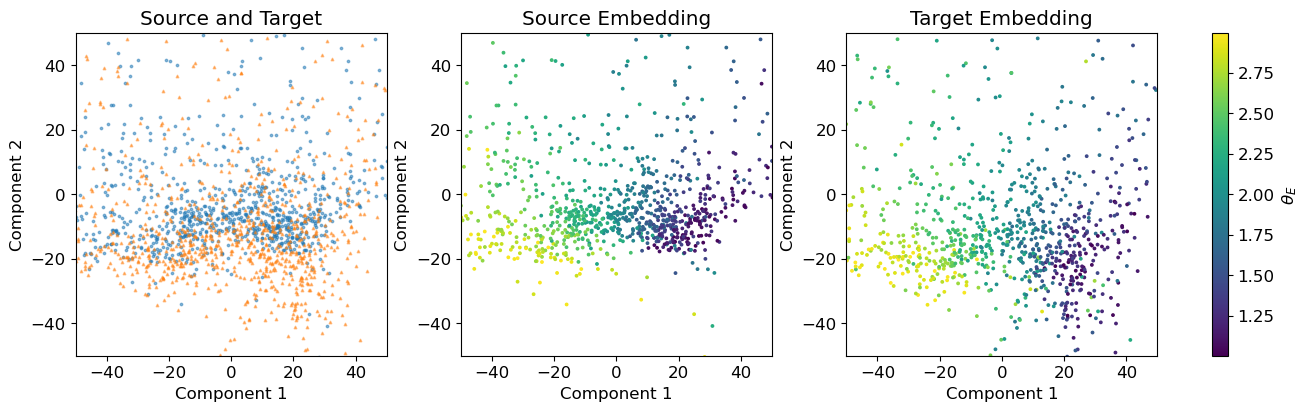


Epoch 180: 63.46s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2364
	Train Regression Loss: : 0.0044
	Train Mve Loss: : -0.0875
	Train R2 Score: : 0.9864
 Validation Statistics:
	Val Source Regression Loss: : 0.0113
	Val Target Regression Loss: : 0.2028
	Val Source R2 Score: : 0.9648
	Val Target R2 Score: : 0.3899
	Val Source Mve Loss: : -0.3724
	Val Target Mve Loss: : 1635.6064

Epoch 181: 63.03s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2349
	Train Regression Loss: : 0.0092
	Train Mve Loss: : -0.4596
	Train R2 Score: : 0.9717
 Validation Statistics:
	Val Source Regression Loss: : 0.0073
	Val Target Regression Loss: : 0.1866
	Val Source R2 Score: : 0.9772
	Val Target R2 Score: : 0.4412
	Val Source Mve Loss: : -0.3264
	Val Target Mve Loss: : 1836.9795

Epoch 182: 67.18s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2344
	Train Regression Loss: : 0.0070
	Train Mve Loss: : -0.4496
	Train R2 Score: :

In [ ]:
print("Beginning Training...")


for curr_epoch in range(stats['epoch_no'], stats['epoch_no'] + n_epoch):

        # Generate isomaps every 20 epochs
        if (curr_epoch % 20 == 0):
            print("Generating Isomap...")
            source_iso, target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, 
                         target_iso, 
                         isomap_source_label_sample, 
                         isomap_target_label_sample, 
                         save_mod_name, 
                         name = stats["epoch_no"], 
                         axlim = 50, save = True)

        # Save best models
        if (len(stats['val_target_r2_score']) > 0):
            
            # Save and overwrite model every best target R2
            if (stats['val_target_r2_score'][-1] > best_target_R2):
                print("Saving Model...", end = ' ')
                save_model(save_mod_name, model, optimizer, stats)
                best_target_R2 = stats['val_target_r2_score'][-1]
                print("Done.")
                
            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_mve_loss'][-1] < best_mve_loss):
                print("Saving Model MVE...", end = ' ')
                mve_name = save_mod_name + "_mve"
                save_model(mve_name, model, optimizer, stats)
                best_mve_loss = stats['val_target_mve_loss'][-1]
                print("Done.")

        
        start_time = time.time()

        beta = beta_function(curr_epoch)
        da_weight = da_weight_function(curr_epoch)

        # Train, backpropagate
        vals = train_loop_mve(source_train_dataloader, 
                              target_train_dataloader, 
                              model,
                              regressor_loss_fn, 
                              da_loss_fn, 
                              optimizer,
                              da_weight, 
                              beta)

        # Test, validate metrics
        vals_validate = test_loop_mve(source_val_dataloader, 
                                      target_val_dataloader,
                                      model, 
                                      regressor_loss_fn, 
                                      beta)

        # Training Metrics
        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])

        # Validation Metrics
        stats['val_source_regression_loss'].append(vals_validate[0])
        stats['val_target_regression_loss'].append(vals_validate[1])
        stats['val_source_r2_score'].append(vals_validate[2])
        stats['val_target_r2_score'].append(vals_validate[3])
        stats['val_source_mve_loss'].append(vals_validate[4])
        stats['val_target_mve_loss'].append(vals_validate[5])
        
        # Other Parameters
        stats['da_weight'].append(da_weight)
        stats['beta'].append(beta)
        stats['epoch_no'] += 1

        print_epoch_scores(stats, curr_epoch, time.time() - start_time)

In [ ]:
# Saves the end result model after running for all stages, as well as the .json of stats

state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
final_mod_name = save_mod_name + "_final"
torch.save(state, final_mod_name)
json.dump(stats, open(final_mod_name+'.json', 'w'))

## Visualize Results

In [10]:
# Loads a model for plotting/viz

viz_mod_name = final_mod_name # "models/start_code_test_4_final"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

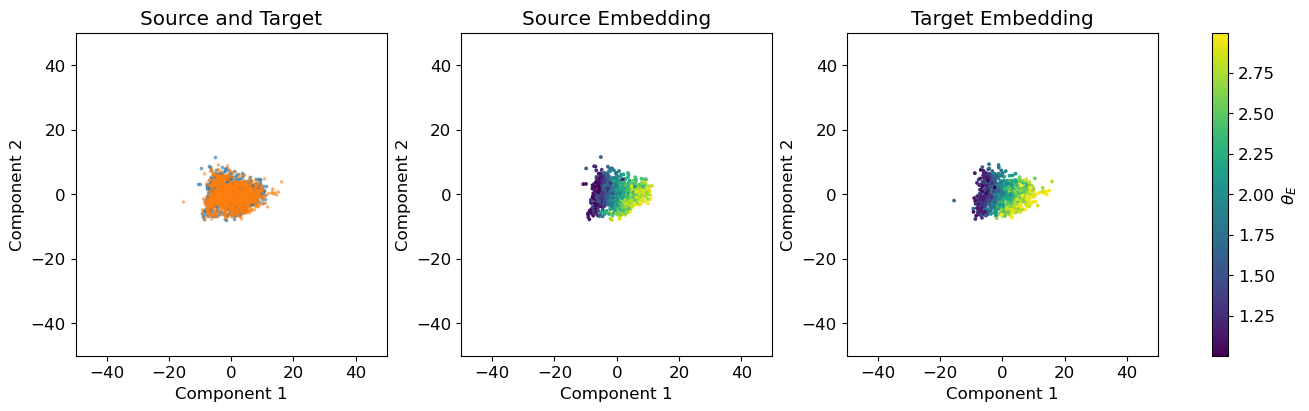

(<Figure size 1300x400 with 4 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Source Embedding'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Target Embedding'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object))

In [11]:
# Visualize isomaps 
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 50)

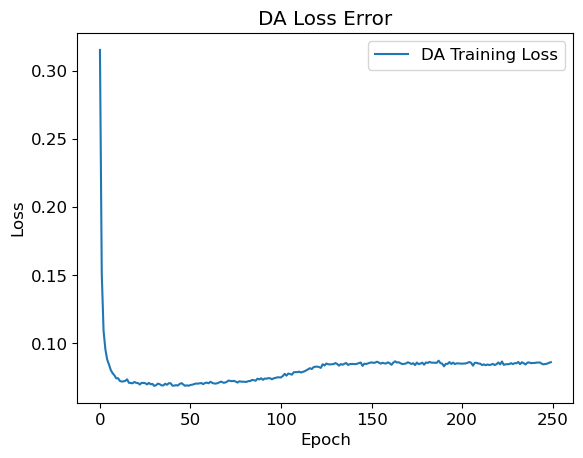

In [12]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

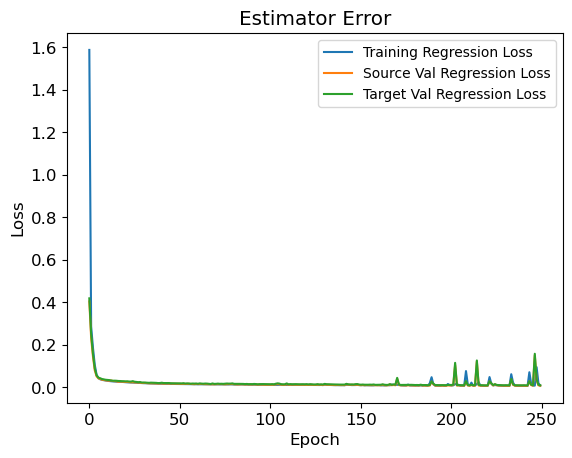

In [13]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

(-1.0, 1.0)

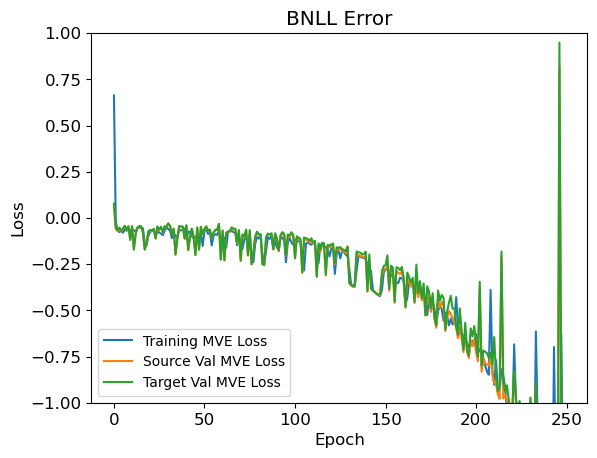

In [14]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 1)

(0.5, 1.0)

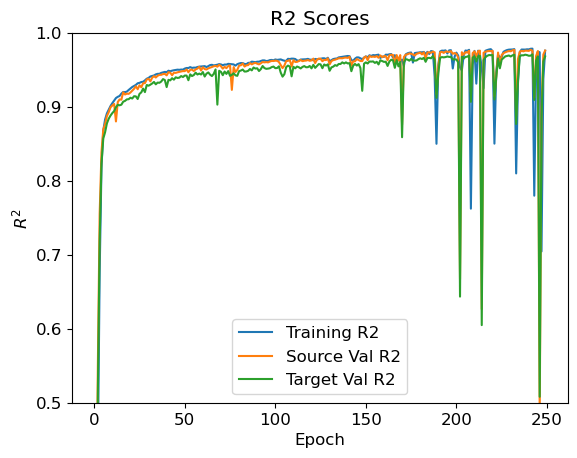

In [15]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.5, 1)

In [26]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

Source R2 Score is 0.9767


Text(0.5, 1.0, 'MMD | Source | R2: 0.977')

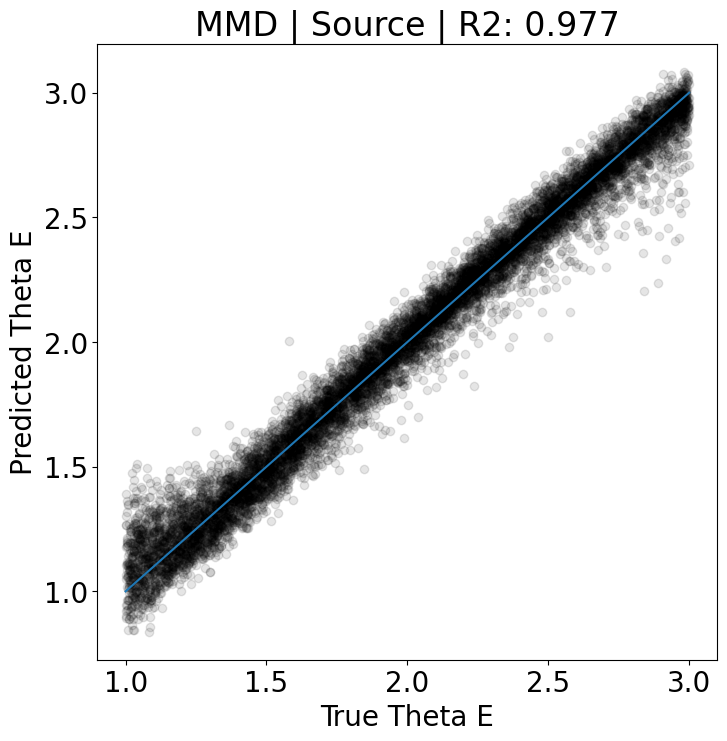

In [27]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | BNLL: -0.175')

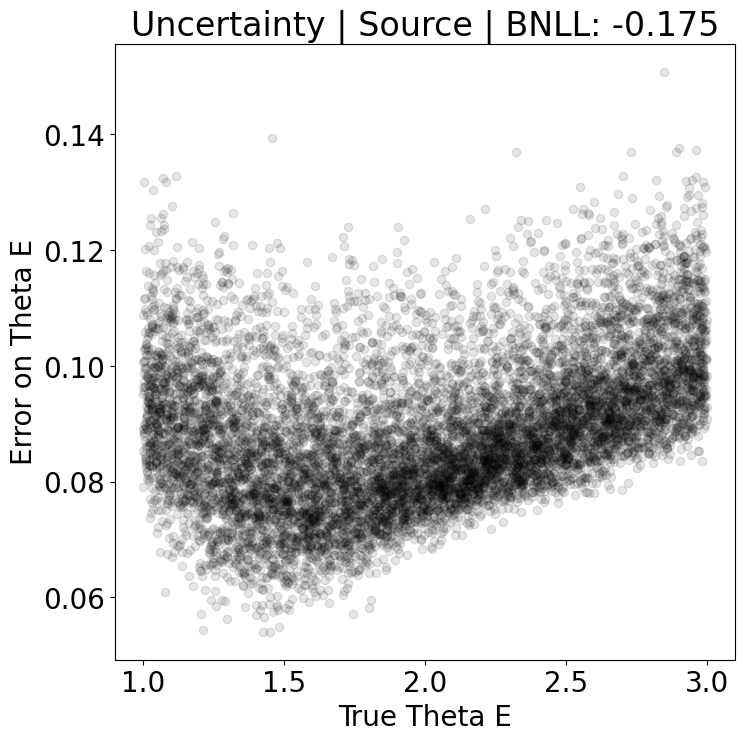

In [28]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [29]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

Target R2 Score is 0.9661


Text(0.5, 1.0, 'MMD | Target | R2: 0.966')

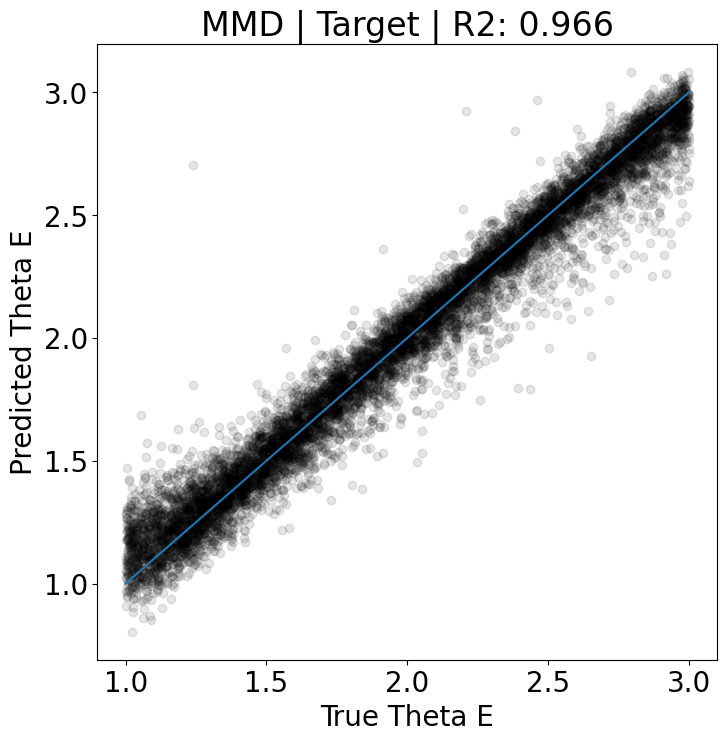

In [30]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'MMD | Target | R2: 0.966')

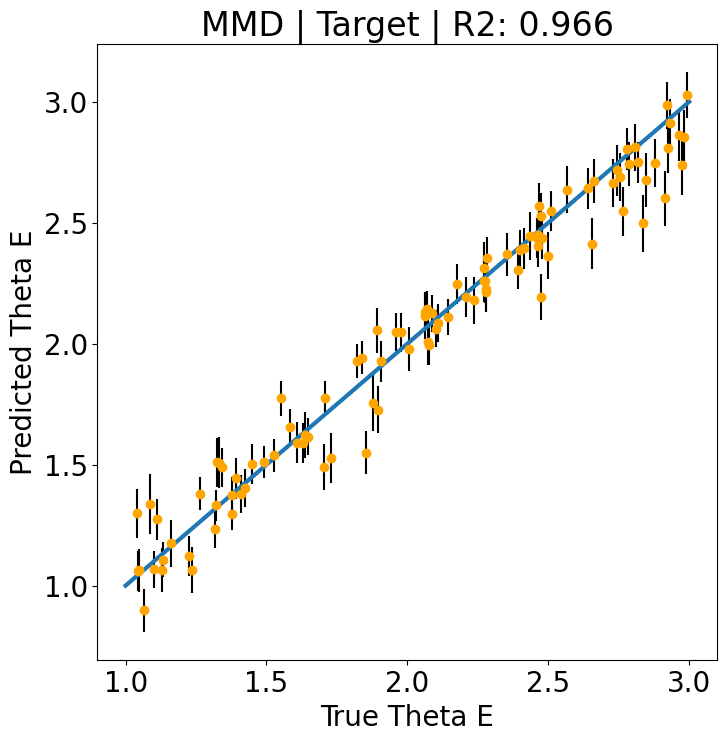

In [31]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: -0.156')

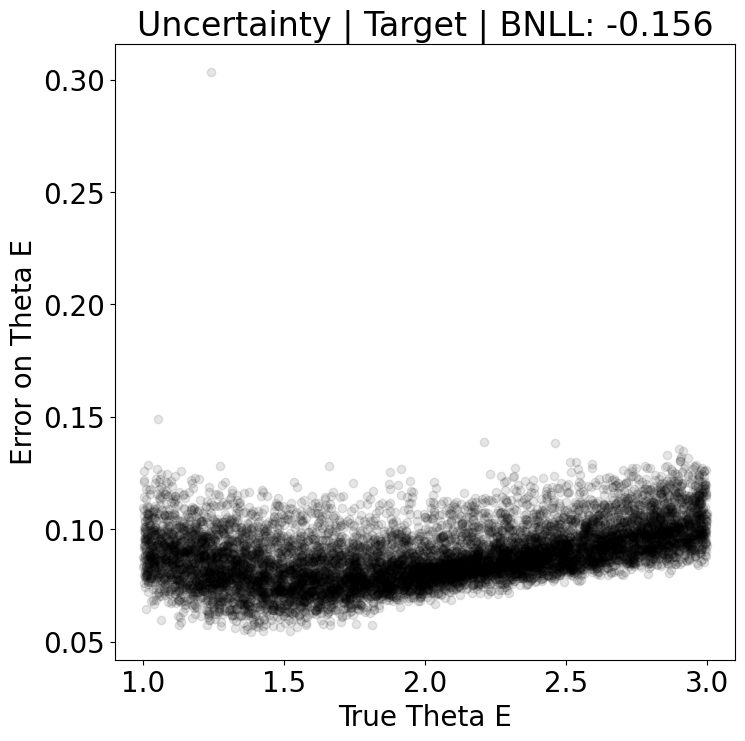

In [32]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [33]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

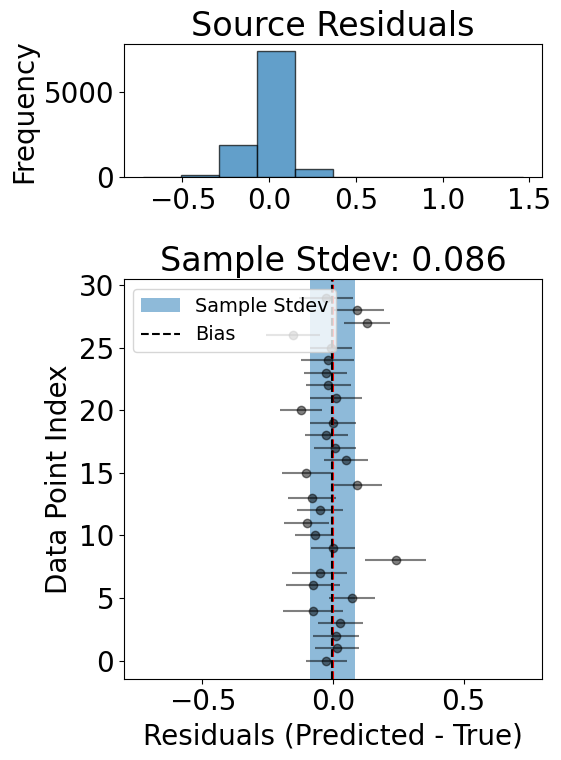

In [34]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

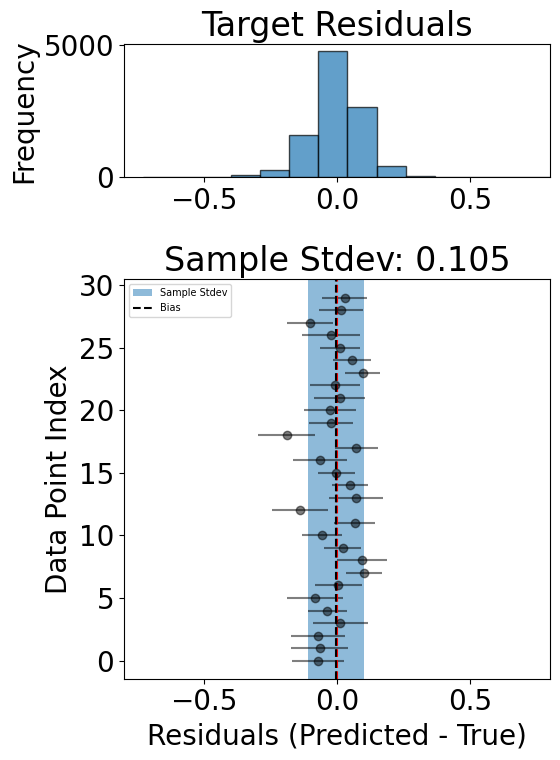

In [38]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=20, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 7)
ax_resid.sharex(ax_hist)

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()